> 
FIGURE A1.4:  Examples of five neurons (5 columns) -- one for OT, one for CN, one for CV, one for CX and one for CO For each neuron, the first row shows the stimulus tuning curve of the neuron. Second row shows the Same curve fitted by Gabor (simple or complex), third row showed the same curve fitted by GLM, forth row showed the same curve fitted by OMP (optional), and fifth row showed the same curve fitted by CNN.  The six row showed the visualization of CNN, started with multiple 3 initial conditions. The seventh row showed top 10 or 20 distinct stimuli (colored those above half height). 
>
>
> Given your most Figure comparing the different models,  maybe this Figure A1.4 can be simplified — i.e. don’t really need the GLM and Gabor fit of the tuning curves, CNN fit example would be enough.  But visualization is still good as a summary description of the model to give intuitive impression. Can discuss tomorrow.
>
> Tai Sing.

For the thesis proposal, I should not include the visualization part, which is kind of cheating (using 192 channel model instead of 12 channel one). For grant proposal, it's OK.

In [1]:
%matplotlib inline
import numpy as np
import h5py
import os.path
import os
import matplotlib.pyplot as plt
import h5py
from scipy.stats import pearsonr, spearmanr
from skimage.io import imsave

In [2]:
from torchvision.utils import make_grid
from torch import FloatTensor

In [3]:
from tang_jcompneuro import dir_dictionary
from tang_jcompneuro.cell_classification import compute_cell_classification
from tang_jcompneuro.cell_stats import compute_ccmax
from tang_jcompneuro.io import load_image_dataset, load_neural_dataset, load_split_dataset
from tang_jcompneuro.model_fitting_postprocess import load_model_performance

In [4]:
model_dict = dict()

model_dict['CNN'] = ('cnn', 'b.4')
dataset_to_check = 'MkA_Shape'
subset_to_check = 'all'

In [5]:
neuron_perf_norm_dict = {x: load_model_performance('MkA_Shape', 'all', '100', 0, y[0], y[1],
                                             load_y_test_hat=True, metric='ccnorm_5', squared=True)
                   for x, y in model_dict.items()}
neuron_perf_abs_dict = {x: load_model_performance('MkA_Shape', 'all', '100', 0, y[0], y[1],
                                             load_y_test_hat=True, metric='raw', squared=True)
                   for x, y in model_dict.items()}
y_all_test = load_split_dataset('MkA_Shape', 'all', True, slice(None))[3] 

In [6]:
folder_to_save =os.path.join(dir_dictionary['plots'], 'main', 'demo_fitted_neurons_for_slides')
os.makedirs(folder_to_save, exist_ok=True)

In [7]:
_get_all_data_cache = dict()
def get_all_data():
    if 'X' not in _get_all_data_cache:
        _get_all_data_cache['X'] = load_image_dataset('Shape_9500', normalize_cnn_format=True)
    if 'y' not in _get_all_data_cache:
        _get_all_data_cache['y'] = load_neural_dataset(dataset_to_check,return_positive=True)
    X, y = _get_all_data_cache['X'], _get_all_data_cache['y']
    assert X.shape == (9500,1,40,40)
    assert y.shape == (9500,1142)
    return X, y

In [8]:
def show_top_stimuli(neuron_idx_this, save_prefix):
    # load actual neuron response
    actual_response_this_ALL = get_all_data()[1][:, neuron_idx_this]
    assert actual_response_this_ALL.shape == (9500,)
    actual_response_sort_idx_ALL = np.argsort(actual_response_this_ALL)[::-1]
    # show top 20 stimuli, 10 x 2.
    X_top_this_ALL = get_all_data()[0][actual_response_sort_idx_ALL[:20]]

    # use torchvision to get a 10 x 2 grid and show it.
    X_top_this_ALL = make_grid(FloatTensor(X_top_this_ALL)[:20], nrow=10, normalize=False, scale_each=False)
    X_top_this_ALL = np.transpose(X_top_this_ALL.numpy(), (1, 2, 0))
    plt.close('all')
    plt.imshow(X_top_this_ALL)
    plt.show()

    # save it.
    imsave(save_prefix+'xtop.png', X_top_this_ALL)

In [9]:
def imshow_inner(npimg, figsize=(8, 6), save_name=None):
    plt.close('all')
    plt.figure(figsize=figsize)
    img_to_show = np.transpose(npimg.numpy(), (1, 2, 0))
    plt.imshow(img_to_show)
    
    if save_name is not None:
        imsave(save_name, img_to_show)
    
    plt.show()

In [10]:
def master_loop():
    cell_class_dict = compute_cell_classification(dataset_to_check,3, readonly=True)
    classes_to_check = ('OT', 'CV',
#                         'CN',
#                         'CRS', 'Other'
                       )
    
    cnn_training_map = {
        'OT': 578,
        'CV': 553,
        'CN': 459,
        'CRS': 1079,
        'Other': 4,
    }
    
    cell_to_check_per_class = 10
    # orientation, curve, corner, cross, composition.
    
    
    top_stimulus_in_curve = 300
    
#     r2abs, r2norm, ccmax = load_raw_and_ccnorm_score()
    
    for cell_class in classes_to_check:
        class_label_this = cell_class_dict[cell_class]
        r2abs = neuron_perf_abs_dict['CNN']['corr'].copy()
        r2norm = neuron_perf_norm_dict['CNN']['corr'].copy()
        assert class_label_this.shape == r2abs.shape == r2norm.shape == (1142,)
        print(cell_class, class_label_this.sum())
        
        # then, get all cells in that class, check the top {cell_to_check_per_class} ones in terms of raw score.
        
        # I also need their absolute idx among 1142 neurons.
        index_abs_all = np.flatnonzero(class_label_this)
        scores_this_set_abs = r2abs[class_label_this]
        scores_this_set_norm = r2norm[class_label_this]
        
        # these two are very high. I guess it's fine to just use raw score.
        print(pearsonr(scores_this_set_abs, scores_this_set_norm)[0])
        print(spearmanr(scores_this_set_abs, scores_this_set_norm)[0])
        
        high_index_relative = np.argsort(scores_this_set_abs)[::-1]
        high_index_abs = index_abs_all[high_index_relative]
        scores_this_set_abs_sorted = scores_this_set_abs[high_index_relative]
        scores_this_set_norm_sorted = scores_this_set_norm[high_index_relative]
        
        
        scores_norm_to_check = scores_this_set_norm_sorted[:cell_to_check_per_class]
        scores_abs_to_check = scores_this_set_abs_sorted[:cell_to_check_per_class]
        index_to_check = high_index_abs[:cell_to_check_per_class]
        
        # for each one, load all models' responses and scores.
        assert index_to_check.shape == scores_norm_to_check.shape == scores_abs_to_check.shape == (cell_to_check_per_class,)
        x_axis_range = np.arange(1900)
        
        
        
        for neuron_idx_this_dummy, (neuron_idx_this, score_norm_this, score_abs_this) in enumerate(zip(index_to_check,
                                                                   scores_norm_to_check,
                                                                   scores_abs_to_check)):
            print('dummy', neuron_idx_this_dummy, 'real', neuron_idx_this, 'ccnorm2', score_norm_this,
                 'ccabs2', score_abs_this)
            
            save_prefix = os.path.join(folder_to_save, f'{cell_class}_{neuron_idx_this_dummy}_')
            
            show_top_stimuli(neuron_idx_this, save_prefix)
            

            y_all_test_this = y_all_test[:, neuron_idx_this]
            assert y_all_test_this.shape == (1900,)
            y_all_test_this_sortidx = np.argsort(y_all_test_this)[::-1]
            plt.close('all')
            fig, ax_this = plt.subplots(1,1,sharex=True, sharey=True,squeeze=True,
                                     figsize=(3,3))
        
            ax_this.plot(x_axis_range, y_all_test_this[y_all_test_this_sortidx], label='raw')
            ax_this.set_xlim(0, top_stimulus_in_curve)
            ax_this.set_xlabel('stimulus rank')
            ax_this.set_ylabel('response')
                # put on ccnorm^2 for this neuron.
                #print(neuron_idx_this, score_norm_this, score_abs_this)
            fig.subplots_adjust(top=0.98, bottom=0.2, left=0.2, right=0.95, hspace=0.1, wspace=0.1)
            fig.savefig(save_prefix+'curves.pdf', dpi=300)
            plt.show()


OT 427
0.903162730298
0.922616748445
dummy 0 real 630 ccnorm2 0.787271055788 ccabs2 0.72616738209


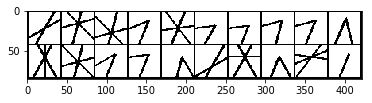

/home/yimengzh/miniconda2/envs/tf15/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


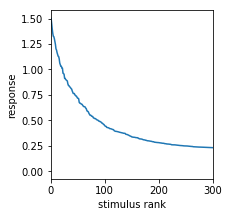

dummy 1 real 33 ccnorm2 0.778625659701 ccabs2 0.714136159908


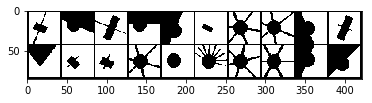

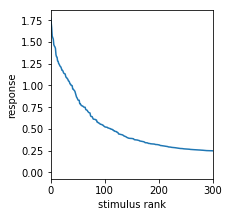

dummy 2 real 103 ccnorm2 0.806855955817 ccabs2 0.712058909154


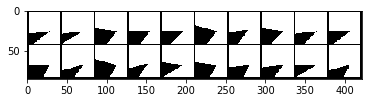

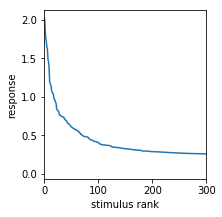

dummy 3 real 415 ccnorm2 0.784509776282 ccabs2 0.709306932649


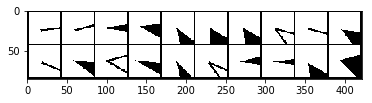

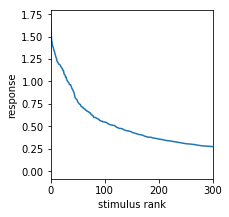

dummy 4 real 1109 ccnorm2 0.79395253624 ccabs2 0.69724009429


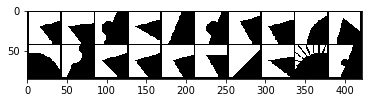

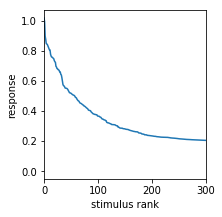

dummy 5 real 797 ccnorm2 0.810671876604 ccabs2 0.682958406551


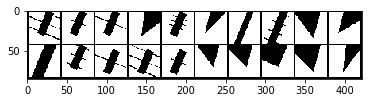

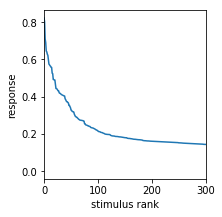

dummy 6 real 356 ccnorm2 0.790719249845 ccabs2 0.68157259462


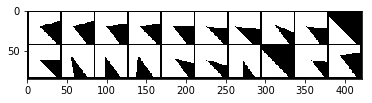

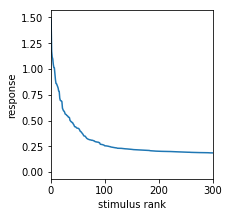

dummy 7 real 578 ccnorm2 0.755995542501 ccabs2 0.677050028799


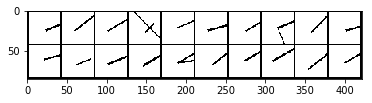

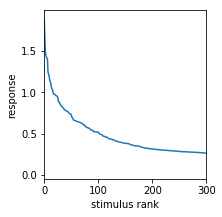

dummy 8 real 114 ccnorm2 0.752512188815 ccabs2 0.663235252665


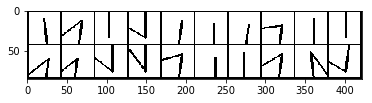

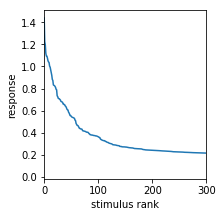

dummy 9 real 637 ccnorm2 0.738459858885 ccabs2 0.649050402741


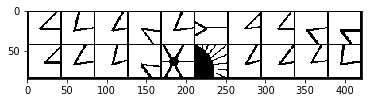

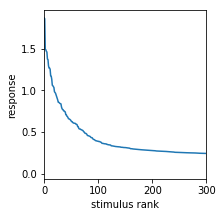

CV 59
0.876581029443
0.941671537113
dummy 0 real 448 ccnorm2 0.77485609564 ccabs2 0.589684583679


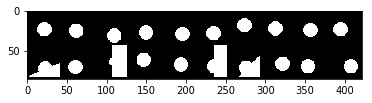

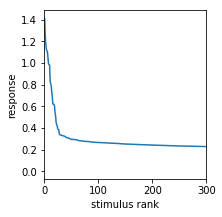

dummy 1 real 1134 ccnorm2 0.658946600219 ccabs2 0.552248971592


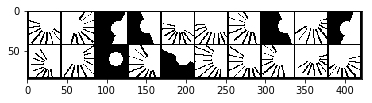

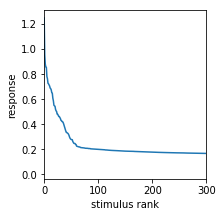

dummy 2 real 351 ccnorm2 0.640673039085 ccabs2 0.50079004237


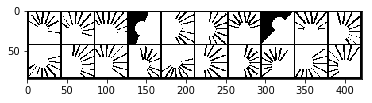

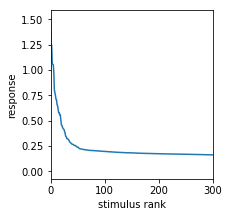

dummy 3 real 838 ccnorm2 0.674577453949 ccabs2 0.499623935149


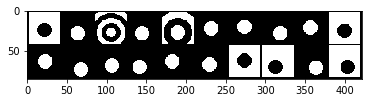

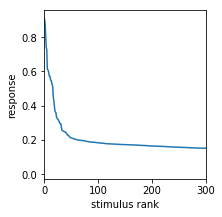

dummy 4 real 323 ccnorm2 0.602390668145 ccabs2 0.482403231903


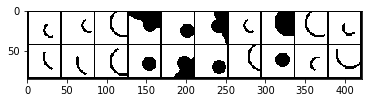

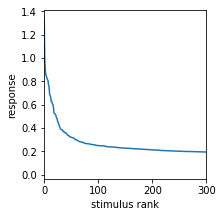

dummy 5 real 553 ccnorm2 0.608118057078 ccabs2 0.456643321834


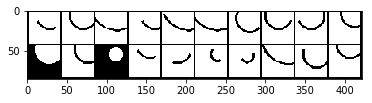

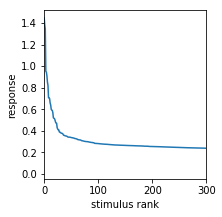

dummy 6 real 275 ccnorm2 0.948215071993 ccabs2 0.445223646186


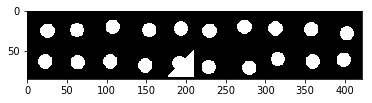

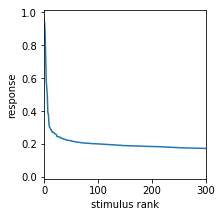

dummy 7 real 9 ccnorm2 0.617663630221 ccabs2 0.422624420742


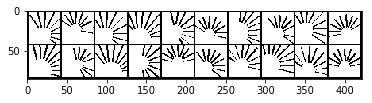

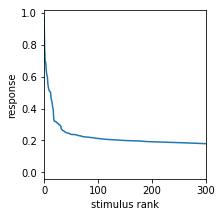

dummy 8 real 857 ccnorm2 0.669729090703 ccabs2 0.404603108156


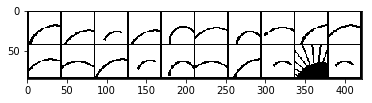

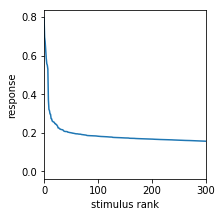

dummy 9 real 2 ccnorm2 0.715113226792 ccabs2 0.350246963483


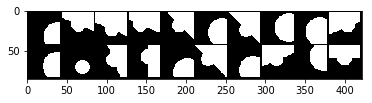

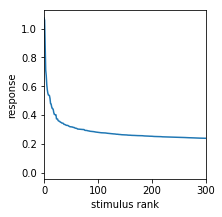

In [11]:
master_loop()